In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
clinical_data = pd.read_csv('/content/drive/My Drive/Projects/multi-view/clinical.csv')

genetic_data = pd.read_csv('/content/drive/My Drive/Projects/multi-view/genetic.csv')

In [ ]:
clinical_data.isnull().sum()

,0
participant_id,0
diagnosis,0
roi0,0
roi1,0
roi2,0
...,...
roi140,0
roi141,0
roi142,0
roi143,0


In [ ]:
genetic_data.isnull().sum()

,0
participant_id,0
SNP0,0
SNP1,0
SNP2,0
SNP3,0
...,...
SNP95,0
SNP96,0
SNP97,0
SNP98,0


In [ ]:
# Merge the datasets on 'participant_id' to ensure both clinical and genetic data have matching participants
merged_data = pd.merge(clinical_data, genetic_data, on='participant_id', how='inner')

# Extract clinical and genetic data matrices
X = merged_data.iloc[:, 2:2 + len(clinical_data.columns) - 1].values
Z = merged_data.iloc[:, 2 + len(clinical_data.columns):].values

In [ ]:
X.shape, Z.shape

((1200, 146), (1200, 98))

In [ ]:
X_scaler = StandardScaler()
X_scaled = X_scaler.fit_transform(X)

Z_scaler = StandardScaler()
Z_scaled = Z_scaler.fit_transform(Z)

In [ ]:

np.random.seed(42)

K = 2
lambda_w = 0.01
lambda_s = 0.0001
max_iter = 150

V = np.random.rand(X.shape[1], K)  # Clinical data weight matrix
W = np.random.rand(Z.shape[1], K)  # Genetic data weight matrix

U = np.zeros((X.shape[0], K))
for i in range(X.shape[0]):
    U[i, np.random.randint(0, K)] = 1  # Assign each participant to one cluster

# Initialize the residual matrix S (for clustering component)
S = np.zeros_like(X)


In [ ]:
def softmax(x):
    # If x is 1D, reshape to 2D for consistent axis handling
    if x.ndim == 1:
        x = x.reshape(1, -1)

    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))  # Numerical stability
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)


In [ ]:
def update_U(X, V, W, S, Z_scaled, K):
    N = X.shape[0]
    U = np.zeros((N, K))

    # Precompute logits for all samples (N x K)
    logits = Z_scaled @ W
    softmax_probs = softmax(logits)  # Apply softmax to all samples at once

    for i in range(N):
        min_loss = float('inf')
        best_k = -1

        for k in range(K):
            clustering_loss = np.linalg.norm(X[i] - V[:, k] - S[i]) ** 2  
            
            classification_loss = -np.log(np.maximum(softmax_probs[i, k], 1e-10))  

            total_loss = clustering_loss + classification_loss  

            if np.isscalar(total_loss) and total_loss < min_loss:
                min_loss = total_loss
                best_k = k

        U[i, best_k] = 1

    return U


In [ ]:
import numpy as np

def update_V(X, U, S, regularization_strength=1e-6):

    UUT = U.T @ U

    UUT += np.eye(UUT.shape[0]) * regularization_strength

    # Use the pseudo-inverse in case U^T * U is not invertible
    try:
        V = (X - S).T @ U @ np.linalg.pinv(UUT)
    except np.linalg.LinAlgError as e:
        print("Matrix inversion error:", e)
        V = None

    return V


In [ ]:
def update_W(Z, U, W, lambda_w, learning_rate=0.002, max_iter=50):
    N = Z.shape[0]
    K = W.shape[1]

    for i in range(max_iter):
        gradient = np.zeros_like(W)

        # Compute the gradient for all samples and clusters
        for k in range(K):
            zi = Z
            ui_k = U[:, k]

            sigmoid = 1 / (1 + np.exp(-zi @ W[:, k]))

            gradient[:, k] = zi.T @ (sigmoid - ui_k) / N

        # Update weights with regularization
        W -= learning_rate * (gradient + lambda_w * np.sign(W))


    return W


In [ ]:
def update_S(X, V, U):
    S = X - (V @ U.T).T
    return S

In [ ]:
def classification_loss(U, logits):
    probs = softmax(logits)
    return -np.sum(U * np.log(probs + 1e-12))  # Add small epsilon to avoid log(0)


In [ ]:
def compute_loss(X, V, W, U, Z_scaled, S, lambda_w, lambda_S):

    # Compute clustering loss (Frobenius norm squared)
    clustering_loss = np.linalg.norm(X - (V @ U.T).T , 'fro')**2 / X.shape[0]

    # Compute classification loss
    logits = Z_scaled @ W
    classification_loss_value = classification_loss(U, logits)

    # L1 Regularization for W (sparsity)
    reg_loss = lambda_w * np.sum(np.abs(W))

    # Frobenius regularization for S
    reg_S_loss = lambda_S * np.linalg.norm(S, 'fro')**2

    # Total loss
    total_loss = clustering_loss + classification_loss_value + reg_loss + reg_S_loss

    return total_loss


In [ ]:
import matplotlib.pyplot as plt

losses = []

for iteration in range(max_iter):
    print(f"Iteration {iteration + 1}/{max_iter}")

    V = update_V(X_scaled, U, S)
    W = update_W(Z_scaled, U, W, lambda_w)
    S = update_S(X_scaled, V, U)
    U = update_U(X, V, W, S, Z_scaled, K)

    # Compute and store the loss
    loss = compute_loss(X, V, W, U, Z_scaled, S, lambda_w, lambda_s)

    losses.append(loss)



Iteration 1/150
Iteration 2/150
Iteration 3/150
Iteration 4/150
Iteration 5/150
Iteration 6/150
Iteration 7/150
Iteration 8/150
Iteration 9/150
Iteration 10/150
Iteration 11/150
Iteration 12/150
Iteration 13/150
Iteration 14/150
Iteration 15/150
Iteration 16/150
Iteration 17/150
Iteration 18/150
Iteration 19/150
Iteration 20/150
Iteration 21/150
Iteration 22/150
Iteration 23/150
Iteration 24/150
Iteration 25/150
Iteration 26/150
Iteration 27/150
Iteration 28/150
Iteration 29/150
Iteration 30/150
Iteration 31/150
Iteration 32/150
Iteration 33/150
Iteration 34/150
Iteration 35/150
Iteration 36/150
Iteration 37/150
Iteration 38/150
Iteration 39/150
Iteration 40/150
Iteration 41/150
Iteration 42/150
Iteration 43/150
Iteration 44/150
Iteration 45/150
Iteration 46/150
Iteration 47/150
Iteration 48/150
Iteration 49/150
Iteration 50/150
Iteration 51/150
Iteration 52/150
Iteration 53/150
Iteration 54/150
Iteration 55/150
Iteration 56/150
Iteration 57/150
Iteration 58/150
Iteration 59/150
Iterat

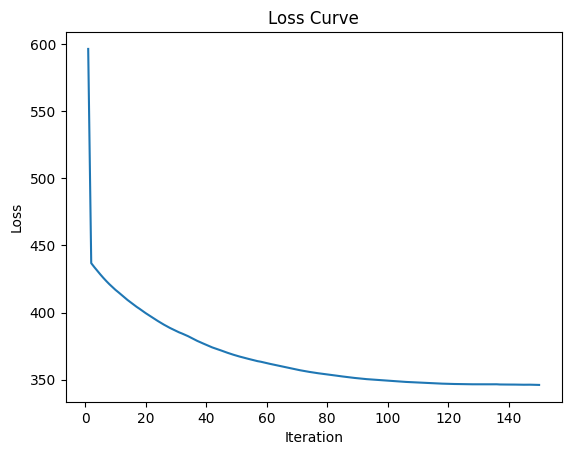

In [ ]:
# Plot the loss curve
plt.plot(range(1, len(losses) + 1), losses)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.show()